In [36]:
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs
import numpy as np

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [38]:
torch.cuda.get_device_name(0)

'Tesla P4'

In [39]:
DATA_PATH = Path('./data/')

In [40]:
train_loader, valid_loader, test_loader = mnist(batch_size=5000, valid=10000, path=DATA_PATH/'MNIST_data')

In [29]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-2, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(1024)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.1)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [30]:
def train(epoch, models):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)

In [31]:
models = {'default': Net(False, False).to(device), 'bn': Net(True, False).to(device), 
           'drop': Net(False, True).to(device), 'both': Net(True, True).to(device)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [32]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            data = data.to(device)
            target = target.to(device)
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [33]:
for epoch in range(1, 101):
    for model in models.values():
        model.train()
    train(epoch, models)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses default: 2.315179 bn: 2.303780 drop: 2.305553 both: 2.325611
Train Epoch: 1 [50000/50000 (100%)]	Losses default: 1.201086 bn: 0.337023 drop: 0.969770 both: 0.382248
Test set:
default: Loss: 0.9916	Accuracy: 6767/10000 (67%)
bn: Loss: 0.8143	Accuracy: 8340/10000 (83%)
drop: Loss: 0.7102	Accuracy: 8072/10000 (80%)
both: Loss: 0.7675	Accuracy: 8410/10000 (84%)

Train Epoch: 2 [0/50000 (0%)]	Losses default: 0.991885 bn: 0.258243 drop: 0.740776 both: 0.284999
Train Epoch: 2 [50000/50000 (100%)]	Losses default: 0.380685 bn: 0.167972 drop: 0.332707 both: 0.195992
Test set:
default: Loss: 0.3051	Accuracy: 9118/10000 (91%)
bn: Loss: 0.2424	Accuracy: 9333/10000 (93%)
drop: Loss: 0.3189	Accuracy: 9068/10000 (90%)
both: Loss: 0.2466	Accuracy: 9344/10000 (93%)

Train Epoch: 3 [0/50000 (0%)]	Losses default: 0.336396 bn: 0.153757 drop: 0.344560 both: 0.167294
Train Epoch: 3 [50000/50000 (100%)]	Losses default: 0.212218 bn: 0.102933 drop: 0.206772 both: 0.109915
Te

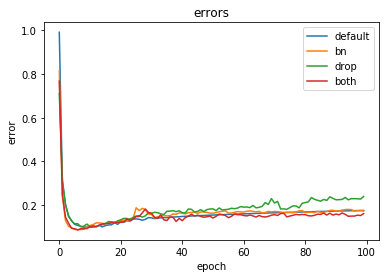

In [34]:
plot_graphs(test_log, 'loss')

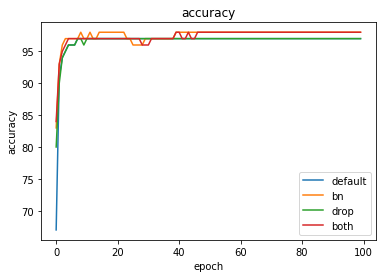

In [35]:
plot_graphs(test_log, 'accuracy')